# Garbage Classification using PyTorch

Import the libraries

In [ ]:
#1.8.1     0.9.1
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
colab = True

드라이브 마운트 & class 확인:

In [ ]:
if colab:
  from google.colab import drive
  drive.mount('/content/drive')
  data_dir  = '/content/drive/MyDrive/캡디/dataset'
  classes = os.listdir(data_dir)
else:
  data_dir  = 'dataset/'
  classes = os.listdir(data_dir)

print(classes)
print(len(classes))

Mounted at /content/drive
['Disposable chopsticks', 'cd', '헤어드라이어', '칫솔', '은박보냉백', '영수증', '알약', '아이스팩', '스파우트파우치', '마스크', '고무장갑', '건전지', '유리', '캔', '계란판', '종이', '플라스틱통', 'PET', '드라이버', '플라스틱', '요구르트병', '종이팩', '스프링노트', '상자']
24


## Transformations:

Dataset 불러오고 변환 후 저장


In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


transformations = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = ImageFolder(data_dir, transform = transformations)

In [ ]:
test_len = int(len(dataset) * 0.1)
train_len = len(dataset) - test_len
train_ds, test_ds = random_split(dataset, [train_len, test_len])
len(train_ds), len(test_ds)

(11698, 1299)

dataset이 잘 불러와졌는지 확인

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def imshow_denormalize(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    imshow_denormalize(img)
    
    
def show_batch(dl):
    images, labels = dl[0]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))

Label: PET (Class No: 1)


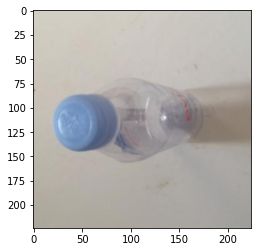

In [ ]:
img, label = dataset[1000]
show_sample(img, label)

Batch가 잘 나눠졌는지 확인하기 위해 시각화


# Model Base:

In [ ]:
def accuracy(outputs, labels):
    """출력과 정답을 비교해 top-1 정확도를 반환"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

##self.backbone = models.resnet50(pretrained=True) 수정



- resnet18 = models.resnet18(pretrained=True)
- alexnet = models.alexnet(pretrained=True)
- squeezenet = models.squeezenet1_0(pretrained=True)
- vgg16 = models.vgg16(pretrained=True)
- densenet = models.densenet161(pretrained=True)
- inception = models.inception_v3(pretrained=True)
- googlenet = models.googlenet(pretrained=True)
- shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
- mobilenet_v2 = models.mobilenet_v2(pretrained=True)
- mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
- mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
- resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
- wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
- mnasnet = models.mnasnet1_0(pretrained=True)

Reference : https://pytorch.org/vision/stable/models.html

In [ ]:
class TrashNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnext50_32x4d(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, len(dataset.classes))
    
    def forward(self, xb):
        return torch.softmax(self.backbone(xb), dim=1)

    def get_loss(self, batch):
        """batch에 대해 cross entropy loss를 계산 후 반환"""
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'validation_loss': loss.detach(), 'validation_acc': acc}

## GPU 병렬 처리:

In [ ]:
def list_to_device(batch, device):
    """list로 된 batch의 각 원소를 device에 올려줌"""
    converted_batch = []
    for data in batch:
        converted_batch.append(data.to(device, non_blocking=True))
    return converted_batch

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'current device = {device}')

current device = cuda


# Training the Model:

This is the function for fitting the model.

In [ ]:
@torch.no_grad()
def evaluate(model, validation_loader):
    model.eval()
    outputs = [model.validation(list_to_device(batch,device)) for batch in validation_loader] # 각 batch별 loss, acc 저장
    
    batch_losses = [x['validation_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['validation_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'validation_loss': epoch_loss.item(), 'validation_acc': epoch_acc.item()}


def fit(epochs, lr, model, train_loader, valid_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.get_loss(list_to_device(batch, device))
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
     
        result = evaluate(model, valid_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        history.append(result)
        print(f"Epoch {epoch+1}: train_loss: {result['train_loss']:.4f}, validation_loss: {result['validation_loss']:.4f}, validation_acc: {result['validation_acc']:.4f}")
    return history

모델 학습:

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

num_epochs = 15
opt_func = torch.optim.Adam
lr = 1.0e-5
batch_size = 32

model = None
history = None
avg_acc = 0
kf = KFold(n_splits=8, shuffle=True)

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_ds)):
    cur_model = TrashNet().to(device)
    print(f'======== fold no.{fold+1} ============')
    
    train_subsampler = SubsetRandomSampler(train_idx)
    valid_subsampler = SubsetRandomSampler(valid_idx)
    train_dl = DataLoader(train_ds, batch_size, sampler=train_subsampler, num_workers=2, pin_memory = True)
    valid_dl = DataLoader(train_ds, batch_size, sampler=valid_subsampler, num_workers=2, pin_memory = True)
    
    cur_history = fit(num_epochs, lr, cur_model, train_dl, valid_dl, opt_func)
    avg_acc += cur_history[-1]['validation_acc'] 
    if not history or cur_history[-1]['validation_acc'] > history[-1]['validation_acc']:
        model = cur_model
        history = cur_history
    
    if fold == 4:
      break

print(f'Average accuracy: {avg_acc / 8}, Maximum accuracy: {history[-1]["validation_acc"]}')

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

======== fold no.1 ============


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: train_loss: 2.8496, validation_loss: 2.5587, validation_acc: 0.7444
Epoch 2: train_loss: 2.5112, validation_loss: 2.4531, validation_acc: 0.8125
Epoch 3: train_loss: 2.4338, validation_loss: 2.3936, validation_acc: 0.8881
Epoch 4: train_loss: 2.3450, validation_loss: 2.3311, validation_acc: 0.9319
Epoch 5: train_loss: 2.3006, validation_loss: 2.3037, validation_acc: 0.9613
Epoch 6: train_loss: 2.2775, validation_loss: 2.2981, validation_acc: 0.9633
Epoch 7: train_loss: 2.2674, validation_loss: 2.2946, validation_acc: 0.9660
Epoch 8: train_loss: 2.2623, validation_loss: 2.2912, validation_acc: 0.9674
Epoch 9: train_loss: 2.2591, validation_loss: 2.2924, validation_acc: 0.9626
Epoch 10: train_loss: 2.2558, validation_loss: 2.2919, validation_acc: 0.9654
Epoch 11: train_loss: 2.2545, validation_loss: 2.2901, validation_acc: 0.9647
Epoch 12: train_loss: 2.2530, validation_loss: 2.2882, validation_acc: 0.9698
Epoch 13: train_loss: 2.2529, validation_loss: 2.2880, validation_acc: 0.

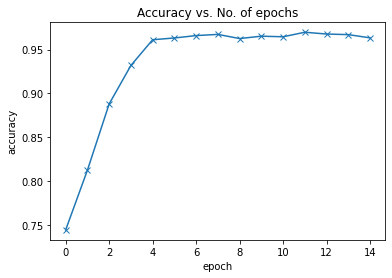

In [ ]:
def plot_accuracies(history):
    accuracies = [x['validation_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

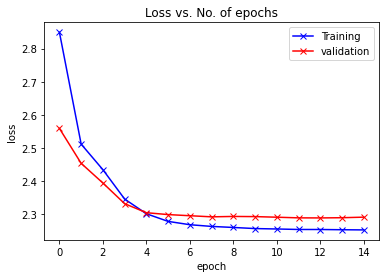

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    validation_losses = [x['validation_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(validation_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

#Test the model

In [ ]:
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory = True)
result = evaluate(model, test_dl)
print(f"Test Acc = {result['validation_acc']}")

Test Acc = 0.9618902206420898


#Saving the model

In [ ]:
Path = '/savedModels/'
FileName = 'resnet18.pt'
torch.save(model, Path+FileName)

# Visualizing Predictions:
Test set에 있는 이미지들 예측 결과입니다.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_ds[102]
#plt.imshow(img.permute(1, 2, 0))
imshow_denormalize(img)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# 직접 찍은 사진들로 테스트한 결과입니다.

savedModels 디렉토리에 저장된 모델을 가져옵니다.
- loaded_model = model : 위에서 학습한 모델 사용
- loaded_model = torch.load('~/modelname.pt') : 모델 불러오기 
- model.eval() : 모델의 모드를 evaluation 모드로 바꿉니다. (prediction을 위해)

Ref : https://tutorials.pytorch.kr/beginner/saving_loading_models.html

In [ ]:
loaded_model = model

'''
loaded_model = TrashNet()
Path = '/savedModels/'
FileName = 'resnext50_32x4d.pt'
loaded_model = torch.load(Path+FileName)
'''
model.eval()

This function takes the image's name and prints the predictions:

In [ ]:
from PIL import Image
from pathlib import Path

image_path = '/test/'
def predict_external_image(image_name):
    image = Image.open(Path(image_path + image_name))
    example_image = transformations(image)
    #plt.imshow(example_image.permute(1, 2, 0))
    imshow_denormalize(example_image)
    print("이 물건은 ", predict_image(example_image, loaded_model) + "입니다.")

In [ ]:
predict_external_image('test_cd2.jpg')

In [ ]:
predict_external_image('test_tooth brush.jpg')

In [ ]:
predict_external_image('test_rubber glove.jpg')

In [ ]:
predict_external_image('test_hairdryer.jpg')

In [ ]:
predict_external_image('test_egg1.jpg')

In [ ]:
predict_external_image('test_PET.jpg')

In [ ]:
predict_external_image('test_yogurt.jpg')

In [ ]:
predict_external_image('test_sd1.jpg')

In [ ]:
predict_external_image('test_sd2.jpg')

In [ ]:
predict_external_image('test_mask1.jpg')

In [ ]:
predict_external_image('test_mask2.jpg')

In [ ]:
predict_external_image('test_notebook1.jpg')

In [ ]:
predict_external_image('test_notebook3.jpg')

In [ ]:
predict_external_image('test_icepack2.jpg')

In [ ]:
predict_external_image('test_receipt1.jpg')

In [ ]:
predict_external_image('test_receipt2.jpg')

In [ ]:
predict_external_image('test_receipt3.jpg')

In [ ]:
predict_external_image('test_receipt4.jpg')

In [ ]:
predict_external_image('test_pill1.jpg')

In [ ]:
predict_external_image('test_pill2.jpg') # 2 class가 한 이미지에 있을 때.  0.6874

#Convert PyTorch models to Core ML

https://developer.apple.com/videos/play/tech-talks/10154/

In [ ]:
!pip install -U coremltools
import coremltools as ct

In [ ]:
sample_img = dataset[0][0]
sample_img = to_device(sample_img.unsqueeze(0), device)

In [ ]:
traced_model = torch.jit.trace(loaded_model, sample_img)
_input = ct.ImageType(
    name = "InputImg",
    shape = sample_img.shape,
    bias = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    scale = 1./(255*0.226)
)
#    
print(sample_img.shape)
print(dataset.classes)
classifier_config = ct.ClassifierConfig(dataset.classes)

In [ ]:
mlmodel = ct.convert(
    traced_model,
    inputs= [_input],
    classifier_config=classifier_config
)

mlmodel.short_description = "Trash Image Classifier"
mlmodel.save("/content/drive/MyDrive/캡디/TrashClassificationModel.mlmodel")

저장...